# Image Segmentation and Cell Size Measurement
 

In [135]:
import numpy as np 
import pandas as pd 
import skimage.io 
import skimage.filters
import skimage.color
import scipy.ndimage
import size.viz 
import size.image
import size.analytical
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import imp 
imp.reload(size.image)
cor, pal = size.viz.matplotlib_style()

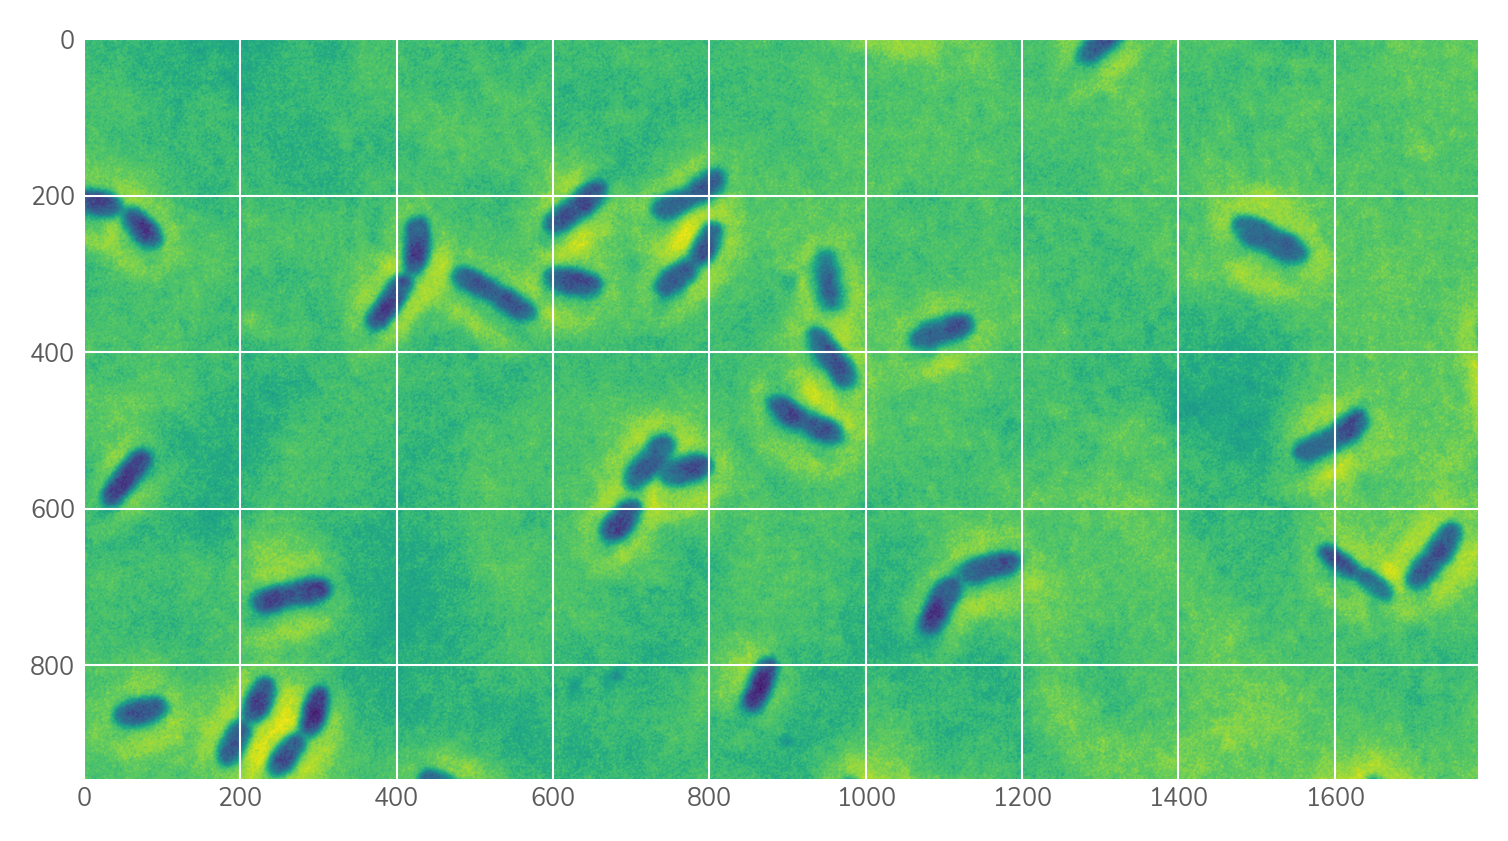

In [128]:
# Load images
files = glob.glob('../../data/images/test/*.tif') 
ims = skimage.io.ImageCollection(files)
test_im = skimage.color.rgb2gray(ims[-1])
crop = test_im[1800:3000, 1800:]
plt.imshow(crop)

In [164]:
# Normalize the image.
selem = skimage.morphology.disk(50)
level=0.05
image = crop
image = (image - image.min()) / (image.max() - image.min())

# Blur and background subtract the image.
im_blur = skimage.filters.gaussian(image, sigma=5)
im_sub = image - im_blur

# Apply the black tophat filter.
im_filt = skimage.morphology.black_tophat(im_sub, selem)

# Find the contours and return.
conts = skimage.measure.find_contours(im_filt, level)

# Make an empty image for adding the approved objects.
objs = np.zeros_like(image)


KeyboardInterrupt: 

In [272]:
ip_dist = 1
perim_bounds = (1, 1E4)
ecc_bounds=(0.1, 1)
area_bounds=(5E2, 5E6)
level=0.3

# # Normalize the image.
image = (crop - crop.min()) / (crop.max() - crop.min())

# # Blur and background subtract the image.
# im_blur = skimage.filters.gaussian(image, sigma=50)
# im_sub = image - im_blur

# # Apply the black tophat filter.
selem = skimage.morphology.disk(50)
im_filt = skimage.morphology.black_tophat(im_sub, selem)

# # Find the contours and return.
conts = skimage.measure.find_contours(im_filt, level)

# Make an empty image for adding the approved objects.
objs = np.zeros(np.shape(image))

# Loop through each contour.
_valid_conts = []
count = 1
for _, c in enumerate(conts):
    perim = 0
    for j in range(len(c) - 1):
        # Compute the distance between points.
        distance = np.sqrt((c[j + 1, 0] - c[j, 0])**2 +
                           (c[j + 1, 1] - c[j, 1])**2)
        perim += distance * ip_dist

    # Test if the perimeter is allowed by the user defined bounds.
    if (perim > perim_bounds[0]) & (perim < perim_bounds[1]):

        # Round the contours.
        c_int = np.round(c).astype(int)
        _valid_conts.append(c)

        # Color the image with the contours and fill.
        _objs = np.zeros_like(image)
        _objs[c_int[:, 0], c_int[:, 1]] = count
        fill = scipy.ndimage.binary_fill_holes(_objs)
        fill = skimage.morphology.remove_small_objects(fill)
        objs += (fill * count).astype(int)
        count += 1

# # Fill and label the objects.
# objs_fill = scipy.ndimage.binary_fill_holes(objs)
# # objs_fill = skimage.morphology.remove_small_objects(objs_fill)
# im_lab = skimage.measure.label(objs)#_fill)

# Apply filters.
approved_obj = np.zeros_like(objs.astype(int))
props = skimage.measure.regionprops(objs.astype(int))
valid_conts = []
for i, prop in enumerate(props):
    area = prop.area * ip_dist**2
    ecc = prop.eccentricity
    if (area < area_bounds[1]) & (area > area_bounds[0]) &\
        (ecc < ecc_bounds[1]) & (ecc > ecc_bounds[0]):# &\
        valid_conts.append(_valid_conts[i])
        approved_obj += (objs == prop.label)
im_lab = skimage.measure.label(approved_obj)


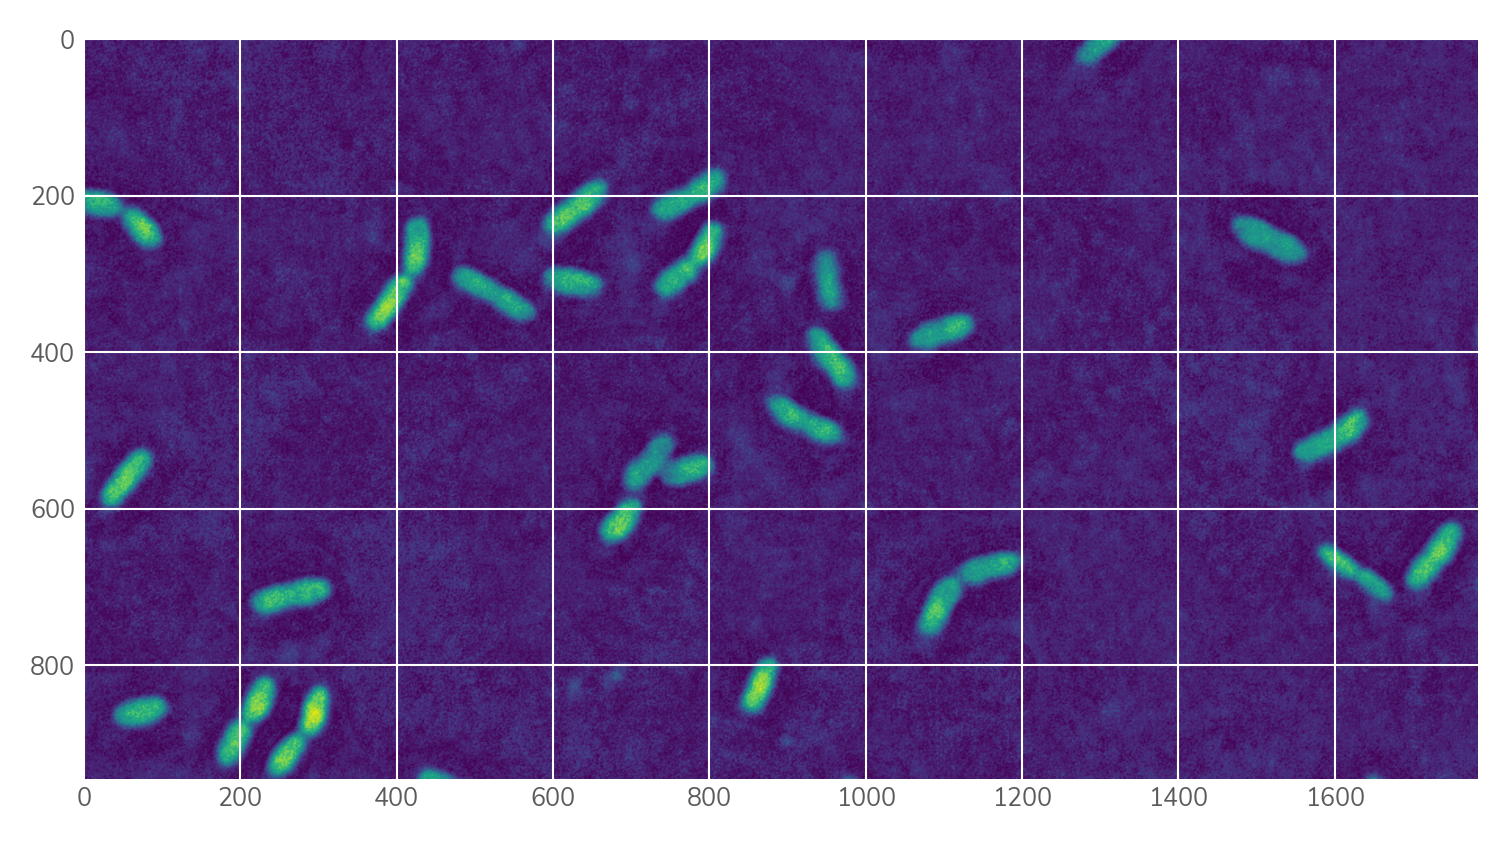

In [326]:
# Watershedding
blackhat = skimage.morphology.black_tophat(im_filt, skimage.morphology.disk(25))
whitehat = skimage.morphology.white_tophat(im_filt, skimage.morphology.disk(25))

fig, ax = plt.subplots(1, 1)
# ax.imshow(whitehat * im_filt)
ax.imshow(whitehat)

In [371]:
# Fancy filter
maxim = scipy.ndimage.filters.maximum_filter(whitehat, footprint=skimage.morphology.disk(1))

minim = scipy.ndimage.filters.minimum_filter(maxim, footprint=skimage.morphology.square(3))



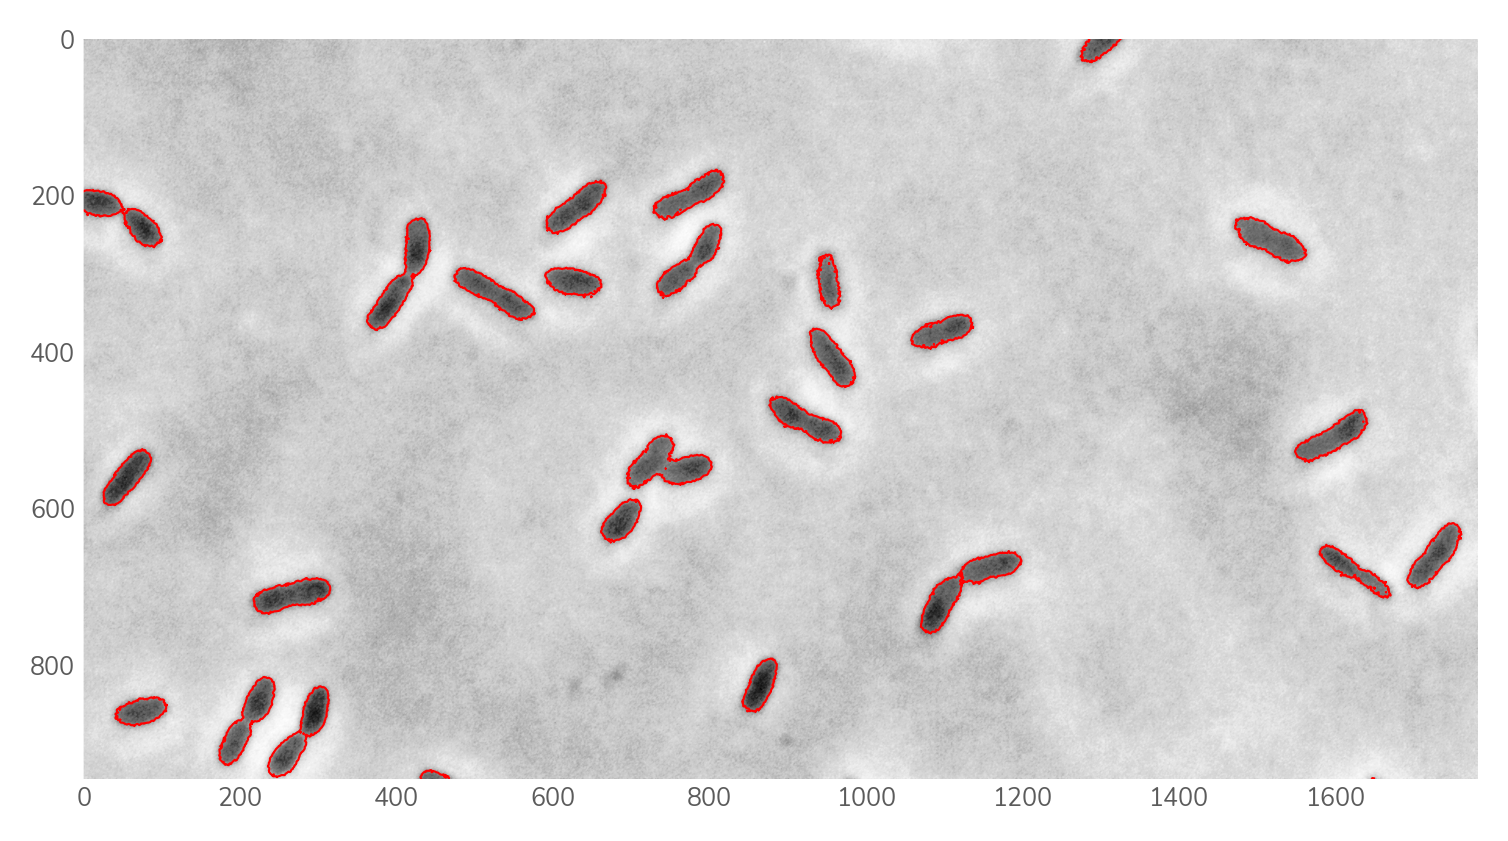

In [377]:
# Find the contours and return.
conts = skimage.measure.find_contours(im_filt, 0.35)
plt.imshow(crop, cmap='Greys_r')

for c in conts:
    plt.plot(c[:, 1], c[:, 0], 'r-')
plt.grid(False)

In [351]:
conts

[array([[0.        , 5.52531513],
        [1.        , 5.17260475],
        [1.13496593, 5.        ],
        [1.17235451, 4.        ],
        [1.13257058, 3.        ],
        [1.53453229, 2.        ],
        [1.53262743, 1.        ],
        [1.        , 0.47406989],
        [0.27594946, 0.        ]]),
 array([[0.       , 2.2786368],
        [0.7082778, 3.       ],
        [0.       , 3.7171061]]),
 array([[1.13718104, 7.        ],
        [1.        , 6.82503578],
        [0.69783601, 7.        ],
        [1.        , 7.30733246],
        [1.13718104, 7.        ]]),
 array([[0.        , 9.16980966],
        [0.30111242, 9.        ],
        [0.2987405 , 8.        ],
        [0.        , 7.70634473]]),
 array([[ 2.37099388, 11.        ],
        [ 2.        , 10.44771667],
        [ 1.        , 10.68539241],
        [ 0.68913475, 11.        ],
        [ 0.82024567, 12.        ],
        [ 1.        , 12.13698875],
        [ 1.18263984, 12.        ],
        [ 2.        , 11.3689008

In [349]:
minim

array([[0.10804612, 0.10804612, 0.10823112, ..., 0.07695884, 0.07786689,
        0.01906079],
       [0.07888817, 0.07888817, 0.10823112, ..., 0.07676279, 0.0776613 ,
        0.01906079],
       [0.0738936 , 0.0738936 , 0.07397741, ..., 0.07656414, 0.0776613 ,
        0.03366524],
       ...,
       [0.05179069, 0.05179069, 0.04446676, ..., 0.04551059, 0.04551059,
        0.03094232],
       [0.05171838, 0.04435413, 0.04435413, ..., 0.04551059, 0.04551059,
        0.06122765],
       [0.05171838, 0.04435413, 0.04435413, ..., 0.08287166, 0.06125521,
        0.06122765]])

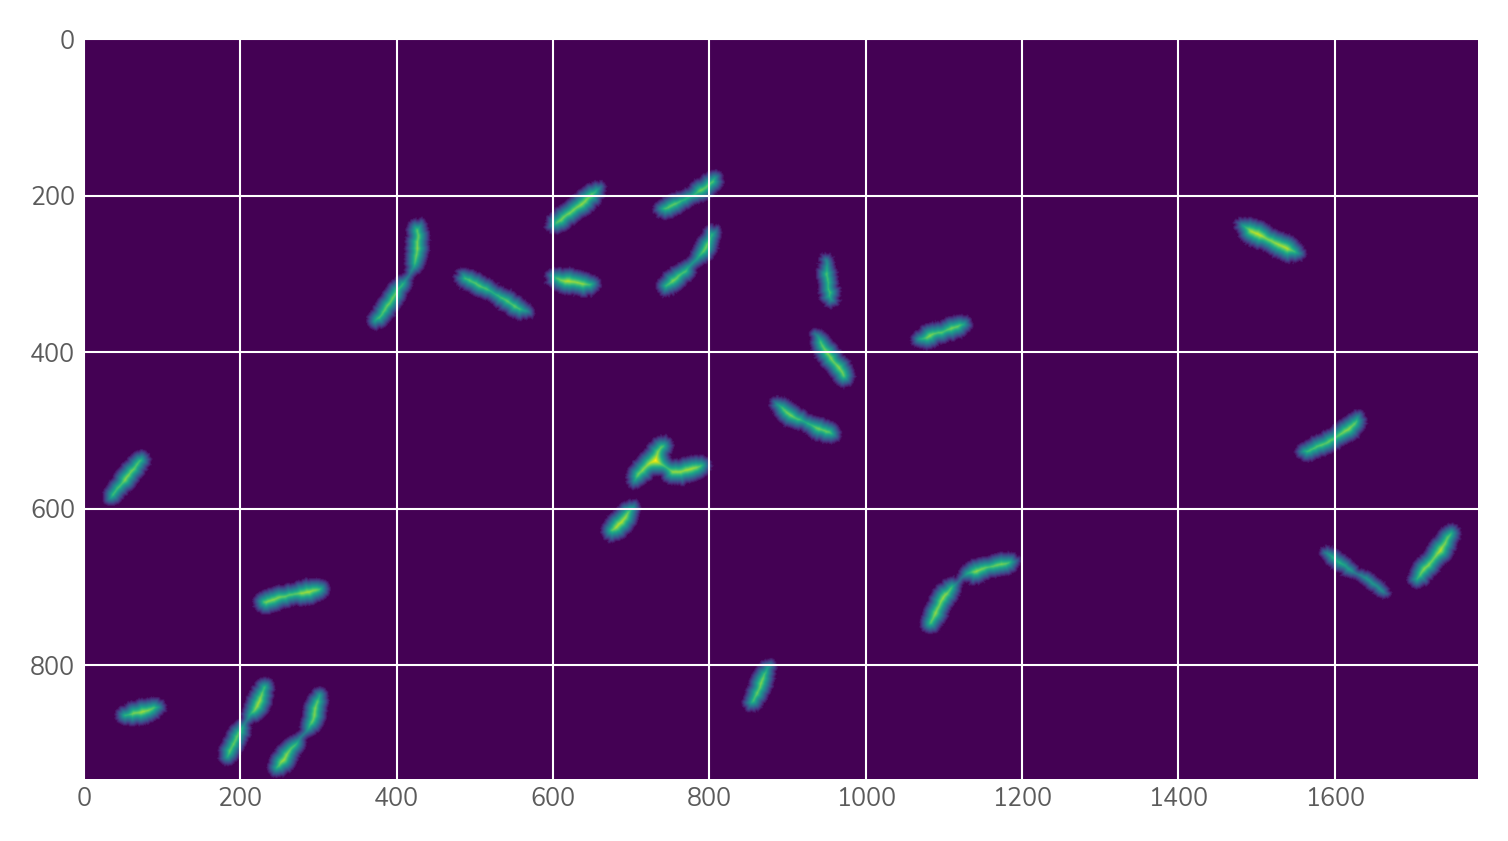

In [310]:
plt.imshow(dst)

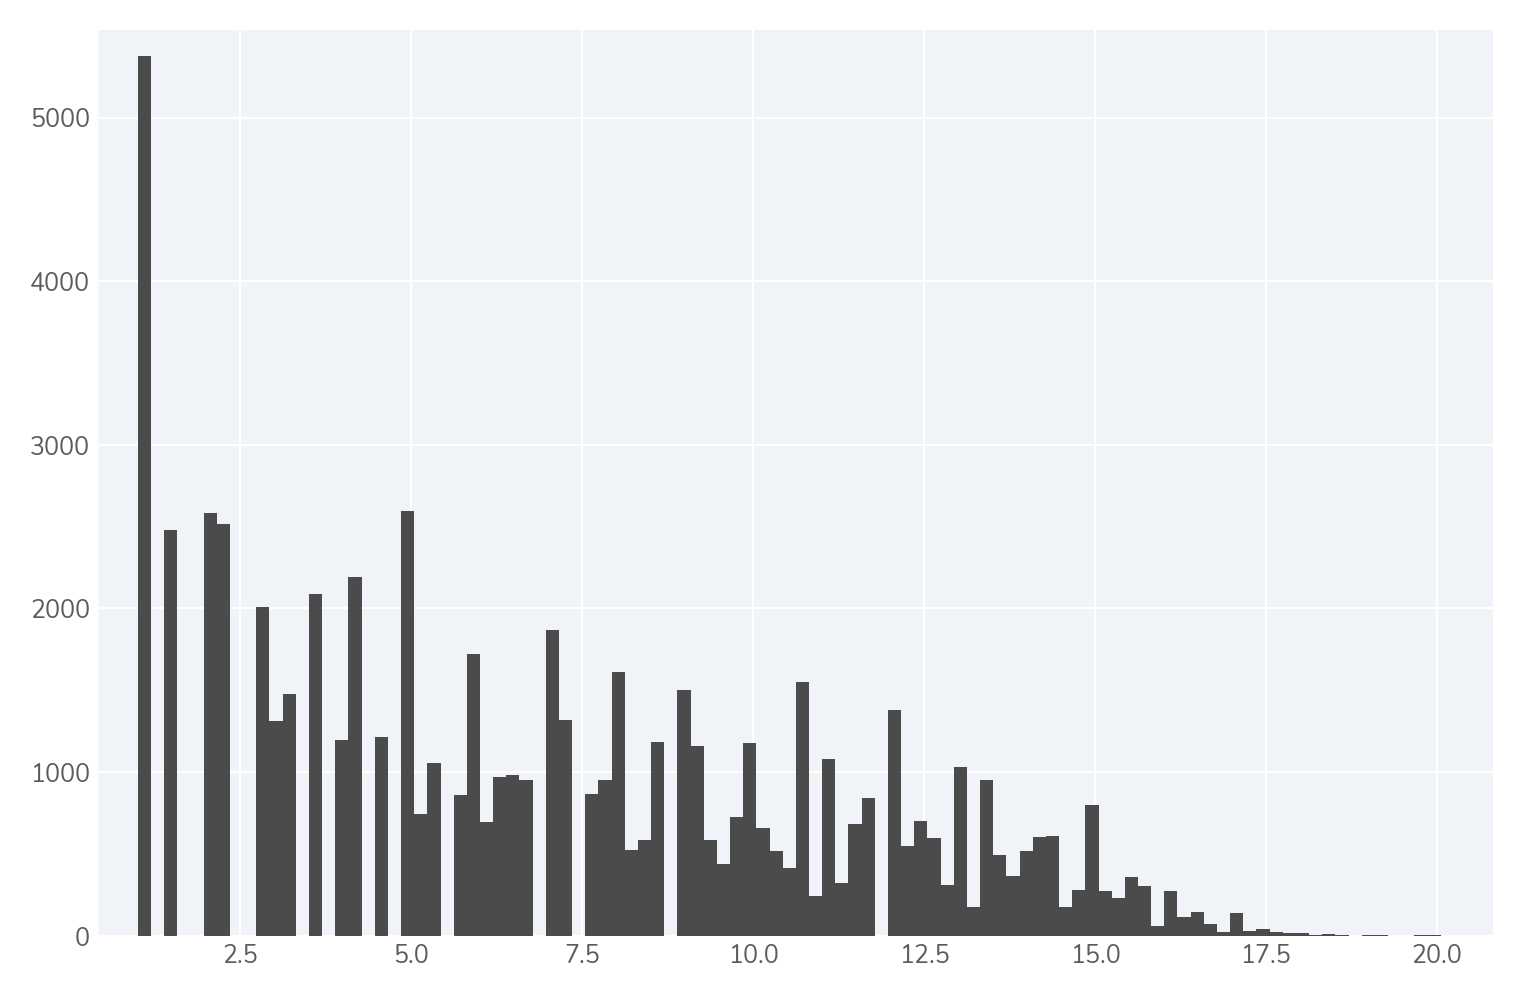

In [304]:
_ = plt.hist(dst[dst > 0].flatten(), bins=100)

In [295]:
spline = scipy.interpolate.SmoothBivariateSpline(c[:, 0], c[:, 1], np.ones(len(c)))

## Finding bottlenecks and clipping